<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Загрузка,-обзор-и-предобработка-данных" data-toc-modified-id="Загрузка,-обзор-и-предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка, обзор и предобработка данных</a></span></li><li><span><a href="#Формирование-признаков-для-моделей-машинного-обучения" data-toc-modified-id="Формирование-признаков-для-моделей-машинного-обучения-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Формирование признаков для моделей машинного обучения</a></span></li><li><span><a href="#Обучение-моделей-и-расчет-целевой-метрики-(f1)" data-toc-modified-id="Обучение-моделей-и-расчет-целевой-метрики-(f1)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей и расчет целевой метрики (f1)</a></span><ul class="toc-item"><li><span><a href="#Модель-Логистическая-регрессия" data-toc-modified-id="Модель-Логистическая-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель Логистическая регрессия</a></span></li><li><span><a href="#Модель-Решающее-дерево" data-toc-modified-id="Модель-Решающее-дерево-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель Решающее дерево</a></span></li><li><span><a href="#Модель-Случайный-лес" data-toc-modified-id="Модель-Случайный-лес-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель Случайный лес</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект

# разработки модели машинного обучения по определению токсичности комментариев
# для интернет-магазина «Викишоп»

## Постановка задачи

Заказчику - Интернет-магазину «Викишоп», в связи с запуском нового сервиса - предоставление пользователям возможности редактировать и дополнять **описания товаров** (как в вики-сообществах) необходимо разработать инструмент - модель машинного обучения (задача бинарной классификации, обучение с учителем), который будет определять токсичные комментарии и отправлять их на модерацию.

От заказчика предоставлен набор данных с разметкой о токсичности правок (столбец *text* - текст комментария, а *toxic* — целевой признак).

Тредование заказчика по качеству работы модели - значение метрики качества **F1** не меньше **0.75**.

**Проект будет выполнен в 3 шага:**

- загрузка, обзор и предобработка данных;
- формирование признаков для моделей машинного обучения;
- обучение различных моделей и подбор лучших гиперпараметров.

## Загрузка, обзор и предобработка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score as f1_s
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold

from sklearn.model_selection import train_test_split as tts

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 100)

In [ ]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Удалим лишнюю колонку "Unnamed: 0".

In [ ]:
data.drop(columns = data.columns[0], axis= 1 , inplace= True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Скопируем колонку 'text' для того, чтобы дальнейшую предобработку комментариев осуществлять уже с данными в отдельной колонке, при этом не потеряв исходный вид (содержание) этих коментариев.

In [ ]:
data['origin_text'] = data['text'].copy()
data = data.reindex(columns=['origin_text', 'text', 'toxic'])

In [ ]:
data.duplicated().sum()

0

Удалим из данных колонки "text" знаки препинания, числа, приведем к нижнему регистру, а разделим строку на отдельные слова (токены).

In [ ]:
def clean_split(text):
    return re.split(' ', (re.sub(r'[\W\d]\s*', ' ', text).lower()))
data['text'] = data['text'].apply(clean_split)

In [ ]:
data.head(10)

,origin_text,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, revert...",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...","[d, aww, he, matches, this, background, colour, i, m, seemingly, stuck, with, thanks, , talk, , ...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...","[hey, man, i, m, really, not, trying, to, edit, war, it, s, just, that, this, guy, is, constantl...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...","[, more, i, can, t, make, any, real, suggestions, on, improvement, , i, wondered, if, the, secti...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?","[you, sir, are, my, hero, any, chance, you, remember, what, page, that, s, on, ]",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk ""","[, congratulations, from, me, as, well, use, the, tools, well, , talk, , ]",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,"[cocksucker, before, you, piss, around, on, my, work]",1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or ...","[your, vandalism, to, the, matt, shirvington, article, has, been, reverted, please, don, t, do, ...",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything i...","[sorry, if, the, word, , nonsense, was, offensive, to, you, anyway, i, m, not, intending, to, wr...",0
9,alignment on this subject and which are contrary to those of DuLithgow,"[alignment, on, this, subject, and, which, are, contrary, to, those, of, dulithgow]",0


Удалим стоп-слова (слова, не несущие значения)

In [ ]:
stop_words = stopwords.words('english')

def del_stop_words(text):
    return [word for word in text if word not in stop_words]

data['text'] = data['text'].apply(del_stop_words)

Приведем слова к первоначальной форме-лемме.

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text]

data['text'] = data['text'].apply(lemmatize)

In [ ]:
data.head(10)

,origin_text,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalism, closure, gas...",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...","[aww, match, background, colour, seemingly, stuck, thanks, , talk, , , , , , , january, , , , , ...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...","[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking,...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...","[, make, real, suggestion, improvement, , wondered, section, statistic, later, subsection, , , t...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?","[sir, hero, chance, remember, page, ]",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk ""","[, congratulation, well, use, tool, well, , talk, , ]",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,"[cocksucker, piss, around, work]",1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or ...","[vandalism, matt, shirvington, article, reverted, please, banned, ]",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything i...","[sorry, word, , nonsense, offensive, anyway, intending, write, anything, article, wow, would, ju...",0
9,alignment on this subject and which are contrary to those of DuLithgow,"[alignment, subject, contrary, dulithgow]",0


Удалим пустые значения в колонке "text".

In [ ]:
def del_na(text):
    return [word for word in text if word!='']
data['text'] = data['text'].apply(del_na)

В результете получаем: "было" - столбец "origin_text", "стало" - столбец "text".

In [ ]:
data.head(10)

,origin_text,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalism, closure, gas...",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...","[aww, match, background, colour, seemingly, stuck, thanks, talk, january, utc]",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...","[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking,...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...","[make, real, suggestion, improvement, wondered, section, statistic, later, subsection, type, acc...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?","[sir, hero, chance, remember, page]",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk ""","[congratulation, well, use, tool, well, talk]",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,"[cocksucker, piss, around, work]",1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or ...","[vandalism, matt, shirvington, article, reverted, please, banned]",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything i...","[sorry, word, nonsense, offensive, anyway, intending, write, anything, article, wow, would, jump...",0
9,alignment on this subject and which are contrary to those of DuLithgow,"[alignment, subject, contrary, dulithgow]",0


**Вывод по разделу:**

В исследуемом датасете изначально было 3 столбца и 159 292 строк. Данные не имели пропусков и полных явных дубликатов строк. Типы данных также не требовали корректировки.

Была произедена предобработка данных:

- удален лишний столбец "Unnamed: 0";
- данные столбца "text" были скопированы в отдельный столбец для сохранения исходного текста коментариев;
- данные столбца "text" были подготовлены к формированию признаков моделей машинного обучаения: тексты приведены к нижнему регистру, слова - к первоначальной форме (лемме), удалены стоп-слова (предлоги, союзы и т.д.. не несущие смысла), тексты комментариев преобразованы в списки слов - токены.

В результате проведенной обработки - получили данные, которые можно использовать для формирования признаков для обучения моделей машинного обучения.

## Формирование признаков для моделей машинного обучения

Разделим датасет на обучающую и тестовую выборки в соотношении 4:1.

In [ ]:
train, test = tts(data, test_size=0.2, random_state=12345)

In [ ]:
train.shape

(127433, 3)

In [ ]:
test.shape

(31859, 3)

Проведем оценку сбалансированности классов позитивных и негативных комментариев:

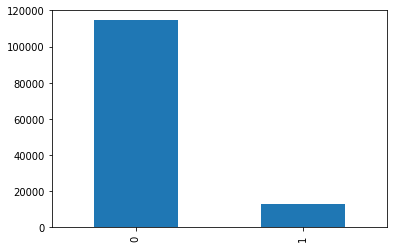

In [ ]:
train['toxic'].value_counts().plot.bar();

По графику очевидна разбалансированность классов в сторону существенно большего объема позитивных комментариев (0), в сравнении с негативными (1).

Данное обстоятельство должно быть учтено при формировании моделей машинного обучения через установление для параметра "вес класса" значения "сбалансированный".

Создадим счетчик TF-IDF

In [ ]:
count_tf_idf = TfidfVectorizer()

Сформируем обучающую и тестовую выборки признаков и целевого признака.

In [ ]:
features_train = train['text'].astype('U')
target_train   = train['toxic']

features_test = test['text'].astype('U')
target_test   = test['toxic']

Применим счетчик TF-IDF к выборкам признаков. Обучим на train и применим к train и test.

In [ ]:
features_train = count_tf_idf.fit_transform(features_train)
features_test  = count_tf_idf.transform(features_test)

## Обучение моделей и расчет целевой метрики (f1)

### Модель Логистическая регрессия

In [ ]:
model_lr = LogisticRegression()

In [ ]:
#grid_lr = GridSearchCV(model_lr, {"C" : range(1,13,1)}, f1_s)
#grid_lr.fit(features_train, target_train)
# поиск параметра С через GridSearchCV , почему-то приводит у "зависанию" Юпитера. :-(.
#Пришлось перебрать руками, меняя в настройках модели.
#model_lr.fit(features_train, target_train)


skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=12345)

param = {'C': range(12,19,2)}

grid_lr = HalvingGridSearchCV(model_lr, param, factor=3, resource='n_samples', max_resources='auto',
                              min_resources='exhaust', aggressive_elimination=False, cv=skf, scoring='f1',
                              refit=True, return_train_score=True, random_state=None, n_jobs=-1, verbose=3)

grid_lr.fit(features_train, target_train)

grid_lr.best_score_

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 42477
max_resources_: 127433
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 42477
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ...........................................C=12; total time=  34.6s
[CV 2/2] END ...........................................C=12; total time=  42.9s
[CV 1/2] END ...........................................C=14; total time=  35.6s
[CV 2/2] END ...........................................C=14; total time=  44.3s
[CV 1/2] END ...........................................C=16; total time=  26.1s
[CV 2/2] END ...........................................C=16; total time=  33.9s
[CV 1/2] END ...........................................C=18; total time=  34.4s
[CV 2/2] END ...........................................C=18; total time=  34.7s
----------
iter: 1
n_candidates: 2
n_resources: 127431
Fitting 2 folds for each of 2 can

0.7571856259926213

In [ ]:
grid_lr.best_estimator_

LogisticRegression(C=16)

### Модель Решающее дерево

In [ ]:
model_dtc= DecisionTreeClassifier()   #class_weight='balanced', max_depth = 12

In [ ]:
param = {'max_depth': range(50,101,10)}

grid_dtc = HalvingGridSearchCV(model_dtc, param, factor=3, resource='n_samples', max_resources='auto',
                              min_resources='exhaust', aggressive_elimination=False, cv=skf, scoring='f1',
                              refit=True, return_train_score=True, random_state=None, n_jobs=-1, verbose=3)

grid_dtc.fit(features_train, target_train)

grid_dtc.best_score_

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 42477
max_resources_: 127433
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 42477
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ...................................max_depth=50; total time=   5.5s
[CV 2/2] END ...................................max_depth=50; total time=   5.4s
[CV 1/2] END ...................................max_depth=60; total time=   6.4s
[CV 2/2] END ...................................max_depth=60; total time=   6.2s
[CV 1/2] END ...................................max_depth=70; total time=   7.1s
[CV 2/2] END ...................................max_depth=70; total time=   6.6s
[CV 1/2] END ...................................max_depth=80; total time=   7.5s
[CV 2/2] END ...................................max_depth=80; total time=   7.6s
[CV 1/2] END ...................................max_depth=90; total time=   8.5s
[CV 2/

0.7228391873867408

In [ ]:
grid_dtc.best_estimator_

DecisionTreeClassifier(max_depth=90)

### Модель Случайный лес

In [ ]:
model_rfc = RandomForestClassifier()  #class_weight='balanced', max_depth = 12

In [ ]:
param = {'max_depth': range(10,111,10), 'n_estimators':range(1,302,50) }

grid_rfc = HalvingGridSearchCV(model_rfc, param, factor=3, resource='n_samples', max_resources='auto',
                              min_resources='exhaust', aggressive_elimination=False, cv=skf, scoring='f1',
                              refit=True, return_train_score=True, random_state=None, n_jobs=-1, verbose=3)

grid_rfc.fit(features_train, target_train)

grid_rfc.best_score_

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 4719
max_resources_: 127433
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 77
n_resources: 4719
Fitting 2 folds for each of 77 candidates, totalling 154 fits
[CV 1/2] END ...................max_depth=10, n_estimators=1; total time=   0.0s
[CV 2/2] END ...................max_depth=10, n_estimators=1; total time=   0.0s
[CV 1/2] END ..................max_depth=10, n_estimators=51; total time=   0.3s
[CV 2/2] END ..................max_depth=10, n_estimators=51; total time=   0.3s
[CV 1/2] END .................max_depth=10, n_estimators=101; total time=   0.5s
[CV 2/2] END .................max_depth=10, n_estimators=101; total time=   0.5s
[CV 1/2] END .................max_depth=10, n_estimators=151; total time=   0.7s
[CV 2/2] END .................max_depth=10, n_estimators=151; total time=   0.7s
[CV 1/2] END .................max_depth=10, n_estimators=201; total time=   1.0s
[CV 2

0.3858647675173156

In [ ]:
grid_rfc.best_estimator_

RandomForestClassifier(max_depth=110, n_estimators=1)

Проверим качество работы лучшей из сформированных моделей (Логистической регрессии) на тестовой выборке.

In [ ]:
pred = grid_lr.predict(features_test)

In [ ]:
f1 = f1_s(target_test, pred)
print('F1 Score:', round(f1, 4))

F1 Score: 0.7888


**Вывод по разделу:**

В результате анализа баланса классов было выявлено существенное преобладание позитивных комментариев, данное обстоятельство было учтено при формировании моделей машинного обучения через применение StratifiedKFold.

Были проверены 3 модели:

- Логистическая регрессия;
- Решающее дерево;
- Случайный лес.

Для всех моделей были подобраны лучшие гиперпараметры.

В результате, только модель **Логистическая регрессия** по требуемому показателю качества (значение метрики F1), соответствует поставленной задаче. Значение F1 для этой модели = 0.757 на обучающей/валидационной выьорке и **0.788 на тестовой**.

**ВЫВОД по проекту:**

Заказчику - интернет магазину "Викишоп" необходимо было разработать модель машинного обучения (задача бинарной классификации, обучение с учителем) для определения токсичности комментариев, которые пользователи могут оставлять в описании товаров. Токсичные комментарии должны отправляться на модерацию.

От заказчика предоставлены исходные данные с разметкой комментариев по токсичности. Объем данных: 159 292 строк и 2 столбца (текст комментария и разметка токсичности).

Необходимо было разработать модель машинного обучения с качеством определения токсичности комментариев по метрике F1 не ниже 0.75.

В результате выполнения проекта:

- данные были предобработаны: комментарии приведены к первоначальной форме слов, удалены стоп-слова;
- проведен анализ сбалансированности классов, результаты которого учтены в параметрах моделей;
- обучено три модели машинного обучения: логистическая регрессия, решающее дерево и случайный лес.
- для каждой модели подобраны лучшие гиперпараметры.


В результате, лучшее значение метрики F1 показала модель Логистической регрессии, для которой на тестовой выборке (при параметре C=16) значение метрики **F1 = 0.7888**.

Данный показатель выше требуемого заказчиком качества (F1 >= 0.75), а значит поставленная задача **успешно выполнена**.